In [583]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import xlrd 
import datetime

In [584]:
def icmp_dateformat_to_datetime(icmp_time_mark):
    """
    Convert ICMP time mark to datetime format
    
    Args:
        icmp_time_mark (float): ICMP time mark
    
    Returns:
        datetime_date (datetime): Datetime format of ICMP time mark
    """
    datetime_date = xlrd.xldate_as_datetime(icmp_time_mark, 0)
    datetime_date = datetime_date + datetime.timedelta(hours=1)
    return datetime_date

In [585]:
def calculate_differences(data):
    """
    Calculate the differences between the timestamps in the data
    
    Args:
    data (pd.DataFrame): Dataframe containing the timestamps
    
    Returns:
    data (pd.DataFrame): Dataframe containing the timestamps and the differences between them
    
    """
    data['diff_sec'] = data['time'].diff().dropna()
    data['diff_sec'] = data['diff_sec'].apply(lambda x: x.total_seconds())
    return data

In [586]:
def time_encoder(df):
  """
  Encode time features from datetime column
  
  Args:
      df (DataFrame): Dataframe to encode time features
      
  Returns:
      df (DataFrame): Dataframe with encoded time features
  """
  df['time'] = pd.to_datetime(df['DateTime'])
  df['hour'] = df['time'].dt.hour
  df['day'] = df['time'].dt.day
  return df

In [587]:
def slice_data_by_diff_in_sampling(data):
    """
    Slice data if there is difference in sampling 
    
    Args:
        data (pd.DataFrame): Data to be sliced
    
    Returns:
        sliced_data (pd.DataFrame): Sliced data
    """
    NORMAL_SAMPLING_VALUE_SECONDS = 60 
    data = calculate_differences(data)
    slices = []
    start_of_a_new_slice = 0
    for i in range(len(data)):
        if data['diff_sec'].iloc[i] != NORMAL_SAMPLING_VALUE_SECONDS:
          slices.append(data.iloc[start_of_a_new_slice:i])
          start_of_a_new_slice = i    
    return slices

In [588]:
def analize_slices(slices):
  """
  Analize slices of data
  
  Args:
      slices (list): List of data slices
  
  Returns:
      None
  """
  for slice in slices:
    plt.plot(slice['ABP'])

In [589]:
def find_outliers(data):
    """
    Find outliers in the data, following the IQR method
    
    Args:
        data (pd.DataFrame): Data to find outliers in
    
    Returns:
        outliers (pd.DataFrame): Outliers in the data

    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))]
    return outliers

In [590]:
data_folder = Path("data") # Path to the data folder
all_csv = list(data_folder.glob("*.csv")) # List of all the csv files in the data folder

In [591]:
data_frames = {}
for file in tqdm(all_csv):
  df = pd.read_csv(file, sep=";", decimal=",") # read csv file
  
  df['DateTime'] = df['DateTime'].apply(icmp_dateformat_to_datetime) # convert icmp time mark to datetime
  df = time_encoder(df) # encode time features
  
  df.set_index('DateTime', inplace=True) 
  data_frames[file.stem] = df # store dataframe in dictionary

100%|██████████| 3/3 [00:00<00:00, 20.81it/s]


In [592]:
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.drop(columns=['TEMP', 'cpp', 'AMP'])

100%|██████████| 3/3 [00:00<00:00, 752.25it/s]


In [593]:
corr_values = []
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.dropna()

100%|██████████| 3/3 [00:00<00:00, 601.65it/s]


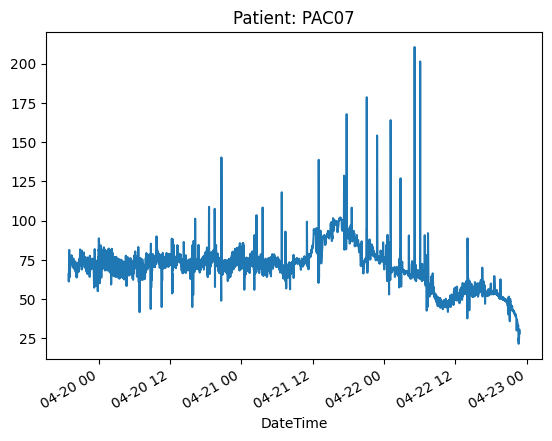

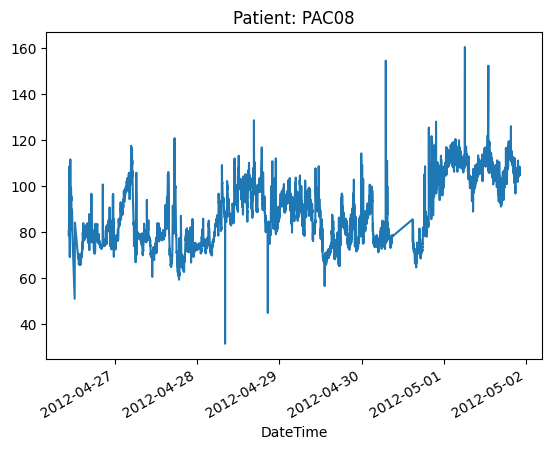

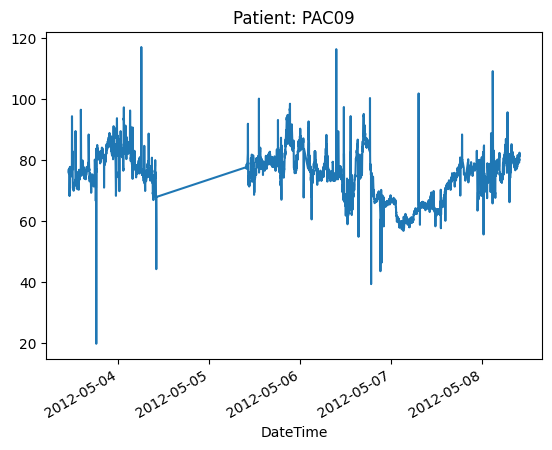

In [594]:
for patient in data_frames.keys():
    data_frames[patient]['ABP'].plot(title=f"Patient: {patient}")
    plt.show()

In [595]:
patient_sliced_data = {}
for patient in data_frames.keys():
  sliced_data = slice_data_by_diff_in_sampling(data_frames[patient])
  patient_sliced_data[patient] = sliced_data

C:\Users\damia\AppData\Local\Temp\ipykernel_13016\3938392293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['diff_sec'] = data['time'].diff().dropna()
C:\Users\damia\AppData\Local\Temp\ipykernel_13016\3938392293.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['diff_sec'] = data['diff_sec'].apply(lambda x: x.total_seconds())


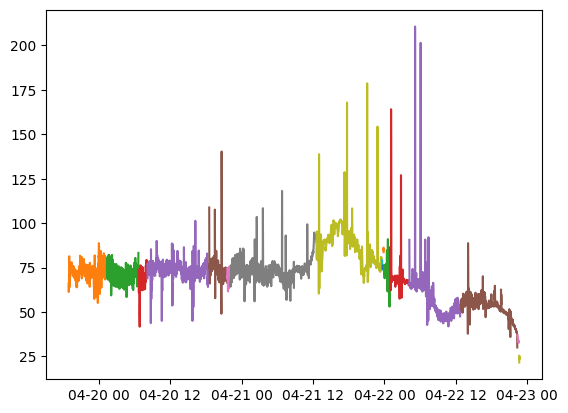

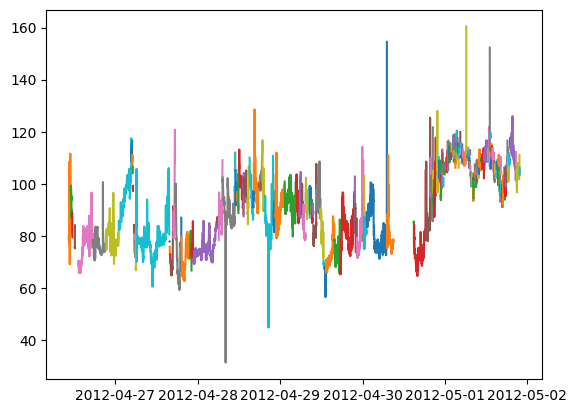

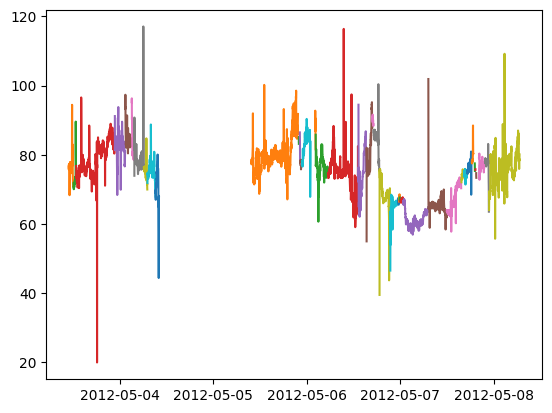

In [596]:
for patient in patient_sliced_data:
  analize_slices(patient_sliced_data[patient])
  plt.show()

In [597]:
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.drop(columns=['day', 'hour', 'time'])

100%|██████████| 3/3 [00:00<00:00, 1002.30it/s]


### Calculate local avergaes and exclude artifacts from analysis 

c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


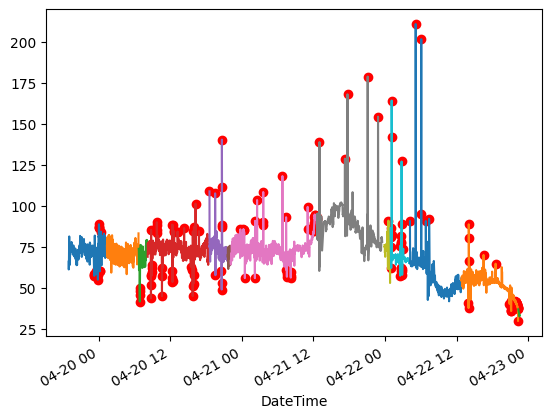

c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


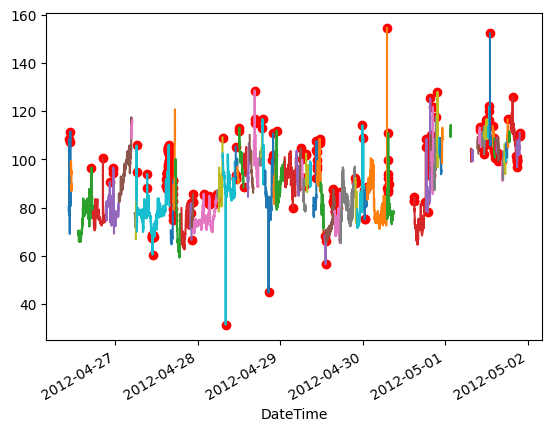

c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


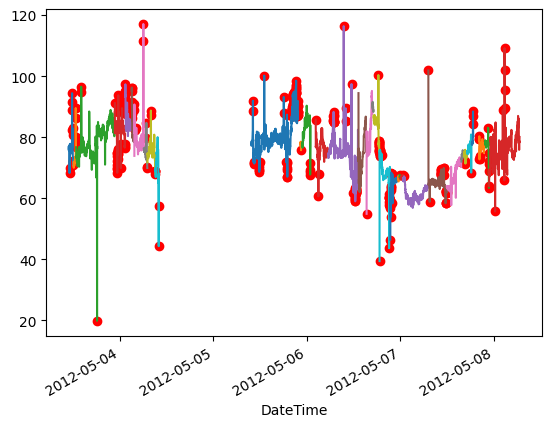

In [598]:
all_outliers = {}
for patient in patient_sliced_data:
  slices = patient_sliced_data[patient]
  slices = [slice for slice in slices if len(slice) > 10]
  outliers_in_slices = [find_outliers(slice_data) for slice_data in slices]
  for i, slice in enumerate(slices):
    slice['ABP'].plot()
    outliers = outliers_in_slices[i]['ABP']
    plt.scatter(outliers.index, outliers, color='red')
  all_outliers[patient] = pd.concat(outliers_in_slices)
  plt.show()

In [602]:
for patient in patient_sliced_data:
  outliers = all_outliers[patient]
  for col in set(data_frames[patient].columns).intersection(outliers.columns):
    common_values = data_frames[patient][col].isin(outliers[col])
    data_frames[patient].loc[common_values, col] = np.nan
  

                           ABP  ABP_BaroIndex  ABP_HRVstats_RMSSD  \
DateTime                                                            
2012-04-19 18:57:17.630  66.00            NaN                 NaN   
2012-04-19 18:58:17.630  61.24            NaN                 NaN   
2012-04-19 18:59:17.630  62.22            NaN                 NaN   
2012-04-19 19:00:17.630  65.75            NaN               9.772   
2012-04-19 19:01:17.630  74.65          1.526                 NaN   
...                        ...            ...                 ...   
2012-04-22 22:41:17.630  23.40          5.637              47.610   
2012-04-22 22:42:17.630  23.69          9.271              44.910   
2012-04-22 22:46:17.630  30.64         18.680             190.400   
2012-04-22 22:47:17.630  29.44         23.640             116.200   
2012-04-22 22:48:17.630  28.20         23.300             113.400   

                         ABP_HRVstats_SDSD  ABP_HRVpsd_LF  ABP_HRVpsd_HF  \
DateTime                  

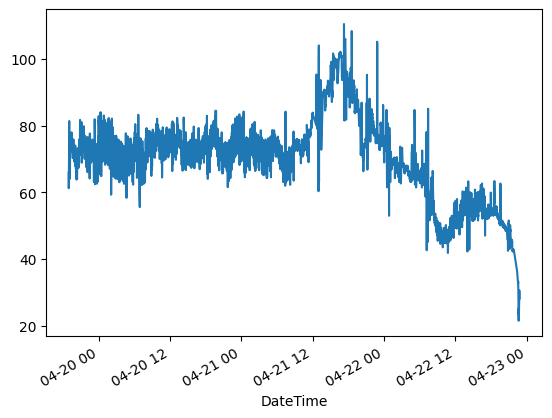

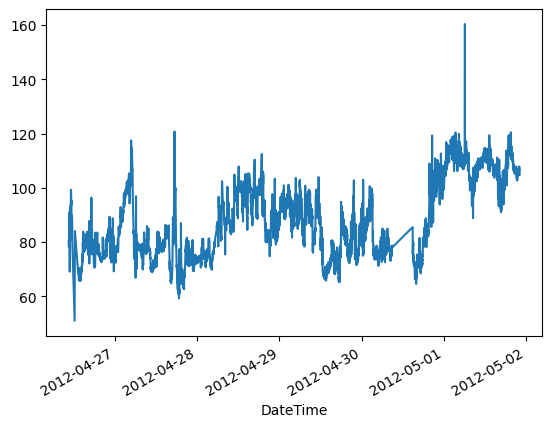

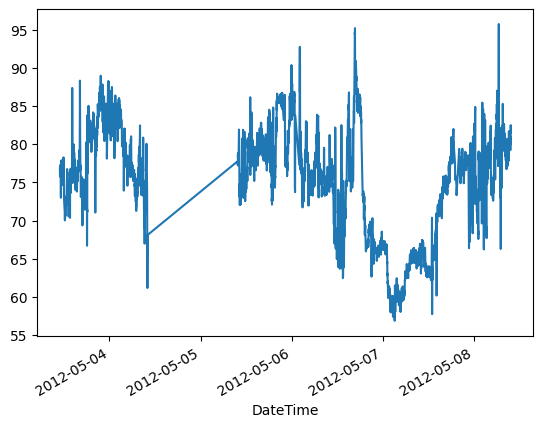

In [606]:
for patient in patient_sliced_data:
  data_frames[patient].interpolate(method='time', inplace=True)
  data_frames[patient]['ABP'].plot()
  plt.show()